In [34]:
# import modules
import numpy as np
from sklearn.datasets import load_digits
from abc import abstractmethod
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score

# Base Classes

In [18]:
class Node:
    '''
      this class will later get the following attributes
      all nodes:
          features
          responses
      split nodes additionally:
          left
          right
          split_index
          threshold
      leaf nodes additionally
          prediction
    '''
        

class Tree:
    '''
      base class for RegressionTree and ClassificationTree
    '''
    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min 
    
    def predict(self, x):
        ''' return the prediction for the given 1-D feature vector x
        '''
        # first find the leaf containing the 1-D feature vector x
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        # finally, return the leaf's prediction
        return node.prediction
        
    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert(responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D)) # number of features to consider for each split decision
        
        # initialize the root node
        self.root = Node()
        self.root.features  = features
        self.root.responses = responses

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None: # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)
    
    def make_split_node(self, node, indices):
        
        if np.unique(node.responses).shape[0] == 1:
            return None, None
            
            # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far 
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None: # no split found
            return None, None

        # create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # turn the current 'node' into a split node
        # (store children and split condition)
        node.left = left
        node.right = right
        node.split_index = j_min
        node.threshold = t_min
        
        # return the children (to be placed on the stack)
        return left, right

    
    def select_active_indices(self, D, D_try):
        ''' return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        return np.random.choice(D, D_try, replace=False)
        
    def find_thresholds(self, node, j):
        ''' return: a 1-D array with all possible thresholds along feature j
        '''
        feature_values = np.unique(node.features[:, j])
        return (feature_values[:-1] + feature_values[1:]) / 2
        
    def make_children(self, node, j, t):
        ''' execute the split in feature j at threshold t
        
            return: left, right -- the children of the split, with features and responses
                                   properly assigned according to the split
        '''
        left = Node()
        right = Node()

        mask = node.features[:, j] <= t
        left.features, left.responses = node.features[mask], node.responses[mask]
        right.features, right.responses = node.features[~mask], node.responses[~mask]
        return left, right
        
    @abstractmethod
    def make_leaf_node(self, node):
        ''' Turn node into a leaf by computing and setting `node.prediction`
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")
        
    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        ''' Return the resulting loss when the data are split along feature j at threshold t.
            If the split is not admissible, return float('inf').
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")


# Regression Tree

In [5]:
class RegressionTree(Tree):
    def __init__(self, n_min=10):
        super(RegressionTree, self).__init__(n_min)
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        ... # your code here
        mask = node.features[:, j] <= t
        left, right = node.responses[mask], node.responses[~mask]

        if len(left) < self.n_min or len(right) < self.n_min:
            return float('inf')
        
        # squared loss
        return np.sum((left - np.mean(left)) ** 2) + np.sum((right - np.mean(right)) ** 2)
        
        #raise NotImplementedError("compute_loss_for_split(): remove this exception after adding your code above.")
        
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a regression tree is a real number)
        node.prediction = np.mean(node.responses) # your code here
        #raise NotImplementedError("make_leaf_node(): remove this exception after adding your code above.")


# Classification Tree

In [27]:
class ClassificationTree(Tree):
    '''implement classification tree so that it can handle arbitrary many classes
    '''
    
    def __init__(self, classes, n_min=10):
        ''' classes: a 1-D array with the permitted class labels
            n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        mask = node.features[:, j] <= t
        left, right = node.responses[mask], node.responses[~mask]

        if len(left) < self.n_min or len(right) < self.n_min:
            return float('inf')
        
        left_impurity = self.gini_impurity(left)
        right_impurity = self.gini_impurity(right)

        return len(left) / len(node.responses) * left_impurity + len(right) / len(node.responses) * right_impurity
    
        
        # Gini impurity calculation
    def gini_impurity(self,responses):
        
        
        impurity = 1
        class_counts = np.bincount(responses, minlength=len(self.classes))
        for count in class_counts:
            proba = count / len(responses)
            impurity -= proba ** 2
        return impurity

        left_impurity = gini_impurity(left)
        right_impurity = gini_impurity(right)
        
        return len(left) / len(node.responses) * left_impurity + len(right) / len(node.responses) * right_impurity

        
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a classification tree is a class label)
        node.prediction = np.argmax(np.bincount(node.responses, minlength=len(self.classes)))
        

# Evaluation of Regression and Classification Tree

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [60]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

(1797, 64) (1797,)


In [ ]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionTree()
# and comment on your results
... # your code here

In [35]:
# perform 5-fold cross-validation with labels 3 and 9
# using ClassificationTree(classes=np.unique(labels))
# and comment on your results
# instantiate the KFold class
kf = KFold(n_splits=5)

# create a list to store performance metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# perform 5-fold cross-validation
for train_index, test_index in kf.split(features):
    # split the data into training and test sets
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = responses[train_index], responses[test_index]
    le = preprocessing.LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)
    

    # create a "Classification Tree"
    clf = ClassificationTree(classes=np.unique(labels))
    clf.train(X_train, y_train)

    # make predictions
    y_pred = [clf.predict(x) for x in X_test]

    # compute performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1) # assuming 1 is the positive class
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    # store performance metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# print average performance metrics
print('Average accuracy:', np.mean(accuracies))
print('Average precision:', np.mean(precisions))
print('Average recall:', np.mean(recalls))
print('Average F1 score:', np.mean(f1_scores))

Average accuracy: 0.859779299847793
Average precision: 0.9189016018306637
Average recall: 0.8088057288057288
Average F1 score: 0.8335829279080054


# Regression and Classification Forest

In [36]:
def bootstrap_sampling(features, responses):
    '''return a bootstrap sample of features and responses
    '''
    # determine the number of data points
    num_data_points = len(features)
    
    # generate a set of random indices with replacement
    bootstrap_indices = np.random.choice(range(num_data_points), size=num_data_points, replace=True)
    
    # use these indices to create a bootstrap sample of the original dataset
    bootstrap_features = features[bootstrap_indices]
    bootstrap_responses = responses[bootstrap_indices]

    return bootstrap_features, bootstrap_responses

In [ ]:
class RegressionForest():
    def __init__(self, n_trees, n_min=10):
        # create ensemble
        self.trees = [RegressionTree(n_min) for i in range(n_trees)]
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        ... # your code here
        raise NotImplementedError("predict(): remove this exception after adding your code above.")

In [37]:
class ClassificationForest():
    def __init__(self, n_trees, classes, n_min=1):
        self.trees = [ClassificationTree(classes, n_min) for i in range(n_trees)]
        self.classes = classes
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        return np.argmax(np.bincount([tree.predict(x) for tree in self.trees], minlength=len(self.classes)))

# Evaluation of Regression and Decision Forest

In [ ]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionForest(n_trees=10)
# and comment on your results
... # your code here

In [93]:
#custom DecisionForest class
class DecisionForest:
    def __init__(self, n_trees, classes):
        self.n_trees = n_trees
        self.classes = classes

    def fit(self, features, responses):
        self.trees = []
        N, _ = features.shape
        for _ in range(self.n_trees):
            # Create a bootstrap sample of the data
            bootstrap_indices = np.random.choice(N, N, replace=True)
            bootstrap_features = features[bootstrap_indices]
            bootstrap_responses = responses[bootstrap_indices]
            # Create a new tree using the bootstrap sample
            tree = ClassificationTree(classes=self.classes)
            tree.train(bootstrap_features, bootstrap_responses)
            # Add it to the forest
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(x) for tree in self.trees for x in X])
        predictions = predictions.reshape((self.n_trees, X.shape[0])).T
        return np.array([np.bincount(p).argmax() for p in predictions])


In [88]:
# perform 5-fold cross-validation with labels 3 and 9
# using DecisionForest(n_trees=10, classes=np.unique(labels))
# and comment on your results
# Create a DecisionForest instance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Assuming `features` is your feature matrix and `labels` are your labels

# Filter data to include only labels 3 and 9
mask = (labels == 3) | (labels == 9)
filtered_features = features[mask]
filtered_labels = labels[mask]

# Initialize the 5-fold cross-validator
cv = StratifiedKFold(n_splits=5)

# Initialize the forest
forest = DecisionForest(n_trees=10, classes=np.unique(filtered_labels))

# Cross-validation
accuracies = []
for train_index, test_index in cv.split(filtered_features, filtered_labels):
    X_train, X_test = filtered_features[train_index], filtered_features[test_index]
    y_train, y_test = filtered_labels[train_index], filtered_labels[test_index]
    
    # Train the DecisionForest
    forest.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = forest.predict(X_test)

    # Compute accuracy and append to list
    accuracies.append(accuracy_score(y_test, y_pred))

print(f"Cross-validation accuracies: {accuracies}")
print(f"Mean cross-validation accuracy: {np.mean(accuracies)}")

Cross-validation accuracies: [0.9178082191780822, 0.8767123287671232, 0.9726027397260274, 0.9861111111111112, 0.9583333333333334]
Mean cross-validation accuracy: 0.9423135464231354


# Multi-class Classification Forest

In [ ]:
# Train DecisionForest(n_trees=10, classes=np.unique(digits.target))
# for all 10 digits simultaneously.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
# Plot the confusion matrix


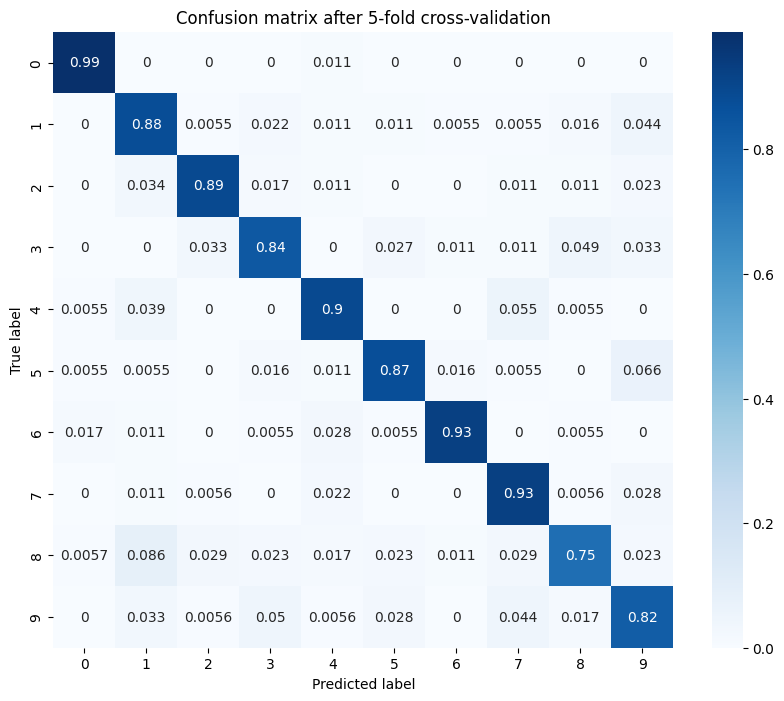

In [89]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits

# Load the digits dataset
digits = load_digits()

# Initialize the 5-fold cross-validator
cv = StratifiedKFold(n_splits=5)

# Initialize the forest with all unique labels
forest = DecisionForest(n_trees=10, classes=np.unique(digits.target))

# Prepare empty confusion matrix
conf_mat = np.zeros((len(forest.classes), len(forest.classes)))

# Cross-validation
for train_index, test_index in cv.split(digits.data, digits.target):
    X_train, X_test = digits.data[train_index], digits.data[test_index]
    y_train, y_test = digits.target[train_index], digits.target[test_index]
    
    # Train the DecisionForest
    forest.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = forest.predict(X_test)

    # Update confusion matrix
    conf_mat += confusion_matrix(y_test, y_pred, labels=forest.classes)

# Normalize confusion matrix
conf_mat /= conf_mat.sum(axis=1, keepdims=True)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=forest.classes, yticklabels=forest.classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix after 5-fold cross-validation')
plt.show()


In [92]:

# Compute the accuracy
accuracy = np.trace(conf_mat) / np.sum(conf_mat)
print("Accuracy: {:.2f}%".format(accuracy * 100))
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score: {:.2f}".format(f1))

Accuracy: 87.90%
F1 Score: 0.86


# Observations:
    -Identify correctly classified digits: Looking at the diagonal elements (top-left to bottom-right) of the matrix. These values represent the number of instances where the true digit and the predicted digit match. we observe Higher values along the diagonal indicate accurate predictions for each digit.
    -Analyze misclassifications: Focusing on the off-diagonal elements of the matrix. These values represent instances where the true digit and the predicted digit do not match. Examining the magnitude of these values, as they indicate the frequency of misclassifications for specific digit pairs, its observed that the 8 has been missclassified as 1 more and even 9 has been misclassified as 3 in some cases and 5 as 9.
    -The model correctly predicted the label correct appox 88% of the time.F1 score of 0.86 means that the model has a relatively high accuracy, with a good balance between precision and recall. It suggests that the model is successful in identifying the correct digit most of the time (86% of the time if we interpret it loosely).




# One-against-the-rest classification with RegressionForest

In [ ]:
# Train ten one-against-the-rest regression forests for the 10 digits.
# Make sure that all training sets are balanced between the current digit and the rest.
# Assign test instances to the digit with highest score, 
# or to "unknown" if all scores are negative.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
... # your code here